# Proj 2: Face beautification
采用局部、全局图像滤波方法，设计能实现人连美颜功能的算法。


In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import cv2

(545, 608, 3)


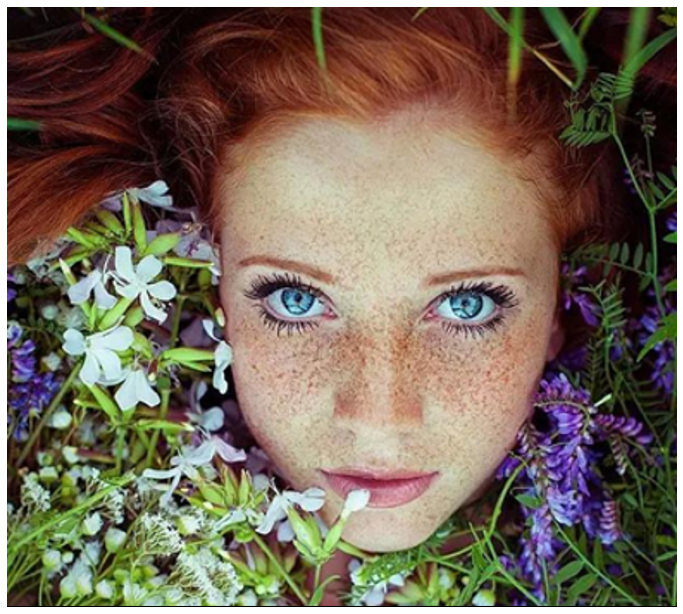

In [291]:
img_origin = cv2.imread('Proj2.png')
print(img_origin.shape)
# show origin image
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
plt.show()

## 1.皮肤区域检测

https://blog.csdn.net/qq_14845119/article/details/121655002

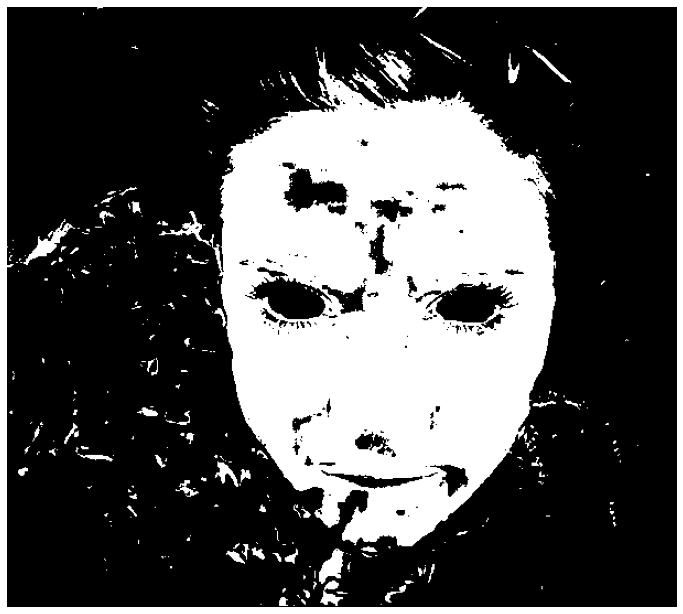

In [451]:
# 在均匀光照下应满足以下判别式：
# R>95 AND G>40 B>20 AND MAX(R,G,B)-MIN(R,G,B)>15 AND ABS(R-G)>15 AND R>G AND R>B
# 在侧光拍摄环境下：
# R>220 AND G>210 AND B>170 AND ABS(R-G)<=15 AND R>B AND G>B

def skinmask_rgb(image):
    b, g, r = cv2.split(image)
    # mask_uniformity = (r>95) * (g>40) * (b>20) * (np.max(image, axis=2)-np.min(image,axis=2)>15) * (abs(r-g)>15)*(r>g)*(r>b)
    mask_uniformity = (r>95) * (g>80) * (b>20) * (np.max(image, axis=2)-np.min(image,axis=2)>15) * (abs(r-g)>5)*(r>g)*(r>b)
    mask_side = (r>220)*(g>210)*(b>170)*(abs(r-g)<=15)*(r>b)*(g>b)
    mask = mask_uniformity | mask_side
    skin = np.array(mask, np.uint8)*255
    ratio = np.sum(skin/255)/(image.shape[0]*image.shape[1])
    return skin, ratio
    
skin, ratio = skinmask_rgb(img_origin)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(skin, 'gray')
plt.savefig("skin_detection.png", bbox_inches='tight', pad_inches=0)
plt.show()

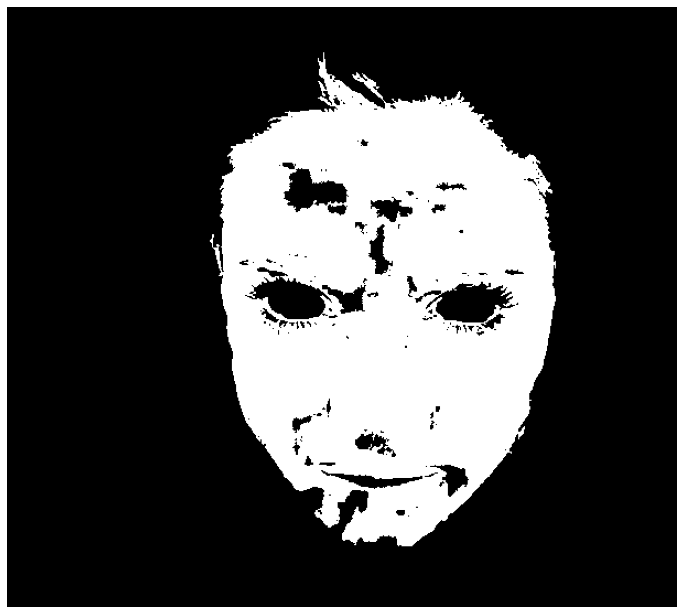

In [453]:
ret, labels, stats, centroid = cv2.connectedComponentsWithStats(skin)
max_area_label = np.argsort(stats[:, -1])[-2]

sk = np.array((labels==max_area_label), np.uint8)*255

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(sk, 'gray')
plt.savefig("bigest_connected.png", bbox_inches='tight', pad_inches=0)
plt.show()

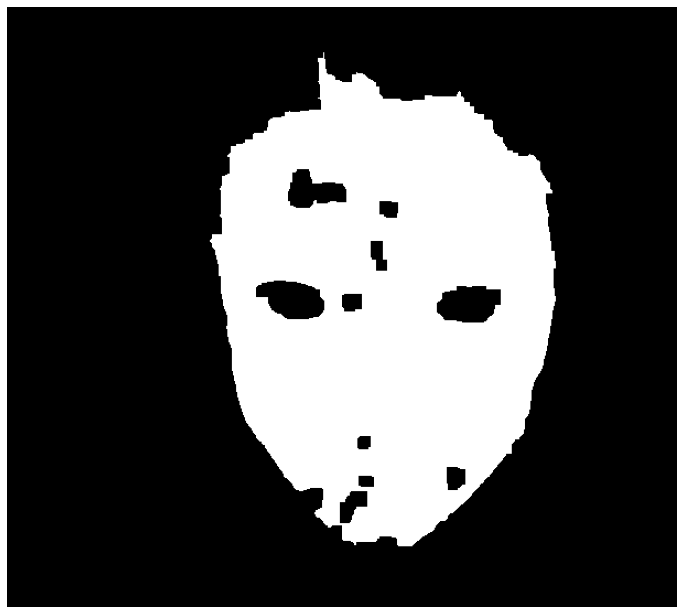

In [452]:
kernel = np.ones((9, 9), dtype=np.uint8)
closing = cv2.morphologyEx(sk, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(closing, 'gray')
plt.savefig("close.png", bbox_inches='tight', pad_inches=0)
plt.show()

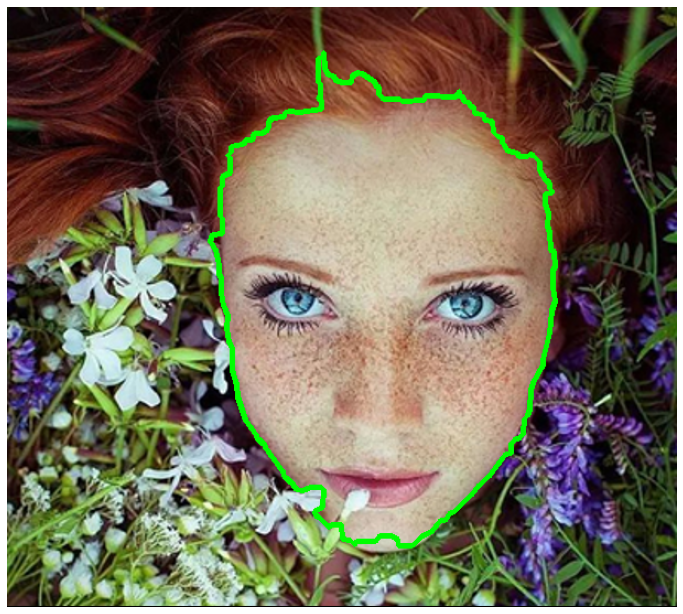

In [454]:
contours, hierarchy = cv2.findContours(closing, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

img1 = img_origin.copy()
approx1 = cv2.approxPolyDP(contours[0], 1, True)
cv2.polylines(img1, [approx1], True, (0,255,0), 3)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.savefig("approxpoly.png", bbox_inches='tight', pad_inches=0)
plt.show()

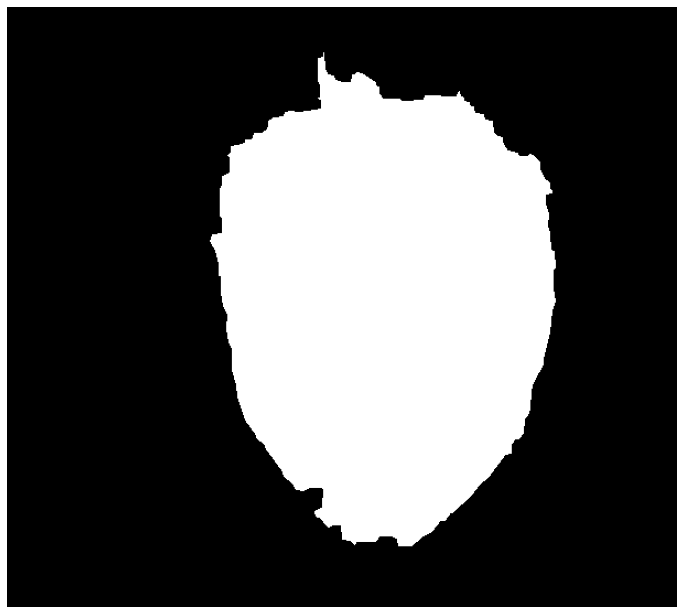

In [443]:
mask = np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8)  # 返回与图像 img1 尺寸相同的全零数组
cv2.fillPoly(mask, [approx1], 255)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(mask, 'gray')
plt.savefig("face_mask.png", bbox_inches='tight', pad_inches=0)
plt.show()

## 2.磨皮祛痘
保边滤波器磨皮算法

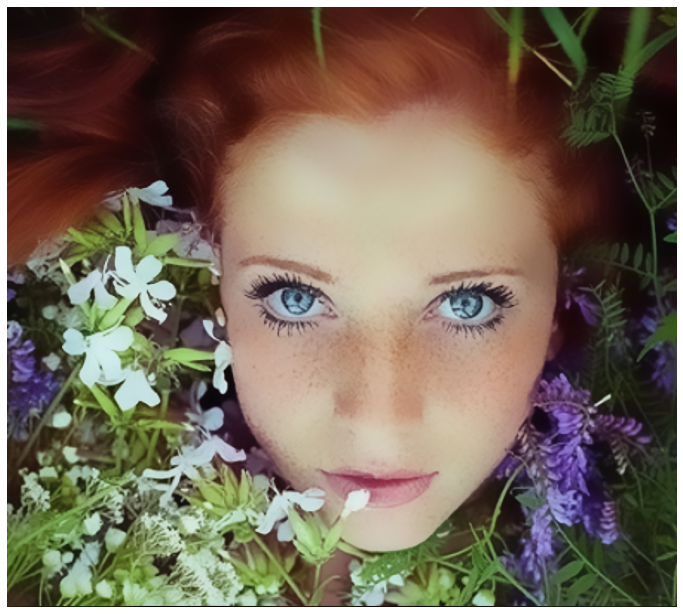

In [444]:
dst = cv2.bilateralFilter(img_origin, 51, 80, 10)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
# save the result
plt.savefig("filtered_image.png", bbox_inches='tight', pad_inches=0)
plt.show()

## 3.掩模融合

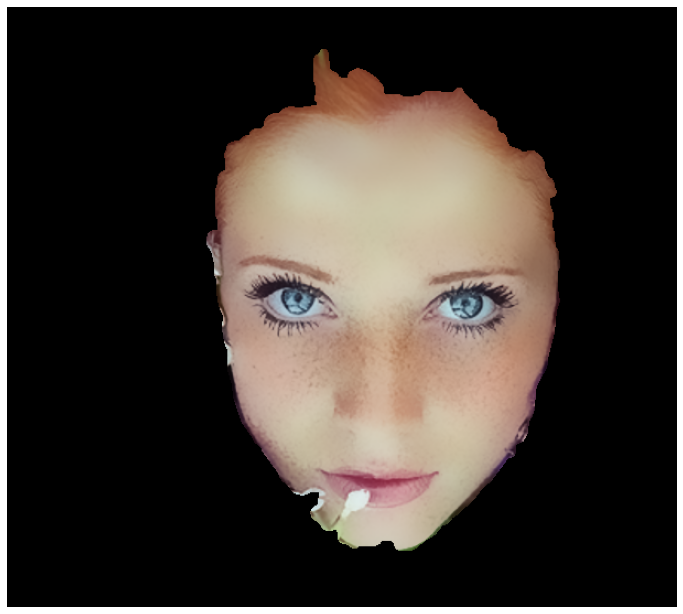

In [450]:
mask = cv2.GaussianBlur(mask, (5, 5), 0, 0)

face_roi = cv2.bitwise_and(dst.copy(), dst.copy(), mask=mask)  # 提取ROI

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))
# save the result
plt.savefig("filtered_face.png", bbox_inches='tight', pad_inches=0)
plt.show()

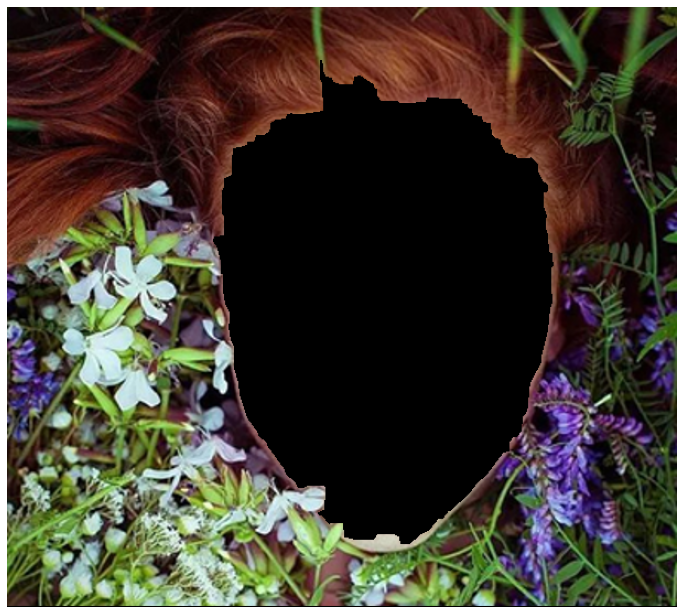

In [449]:
mask_inv = cv2.bitwise_not(mask)
face_roi_inv = cv2.bitwise_and(img_origin.copy(), img_origin.copy(), mask=mask_inv)  # 提取ROI

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(cv2.cvtColor(face_roi_inv, cv2.COLOR_BGR2RGB))
plt.savefig("original_background.png", bbox_inches='tight', pad_inches=0)
plt.show()

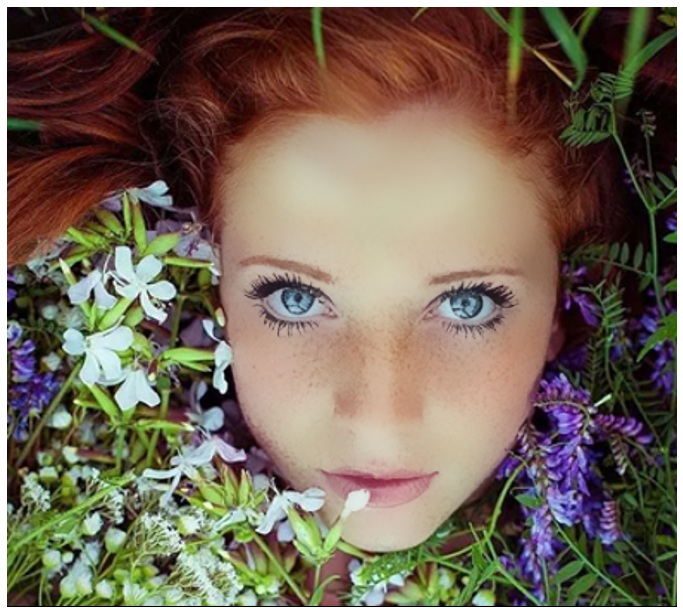

In [448]:
mask_inv = cv2.GaussianBlur(mask_inv, (21, 21), 0, 0)

result = img_origin.copy()
for c in range(img_origin.shape[1]):
    for r in range(img_origin.shape[0]):
        value = mask_inv[r][c]
        if value == 0:
            result[r][c] = dst[r][c]
        if value>0 and value<255:
            result[r][c] = (img_origin[r][c]*(value/255) + dst[r][c]*(1-value/255))

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.savefig("result.png", bbox_inches='tight', pad_inches=0)
plt.show()